In [1]:
# MODULES
from mne.io import read_raw_brainvision
from TFG_utils import (returnFolders, returnFiles, take_vmrk_files, take_vhdr_files, take_eeg_files, plot_eeg_time, plot_PSD, plot_freq_response, get_potencias, ratios)
from TFG_utils import Get_Start_End, Get_spot_start_samples
import matplotlib.pyplot as plt
from mne.preprocessing import ICA
import mne
import numpy as np
from scipy import signal
%matplotlib notebook
import random
import pandas as pd

In [2]:
# COLLECTING DATA
foldername = 'EEG_folders'

EEG_folders=returnFolders(foldername)
EEG_files=returnFiles(EEG_folders)

vmrk_files=take_vmrk_files(EEG_files)
vhdr_files=take_vhdr_files(EEG_files)

eeg_files=take_eeg_files(EEG_files)

In [3]:
verbose=False
i=0 # 1st EEG example

raw = read_raw_brainvision(vhdr_files[i],verbose=verbose).load_data(verbose=verbose)
sampling_freq = int(raw.info['sfreq'])

# FILTERING


 NOTCH FILTER


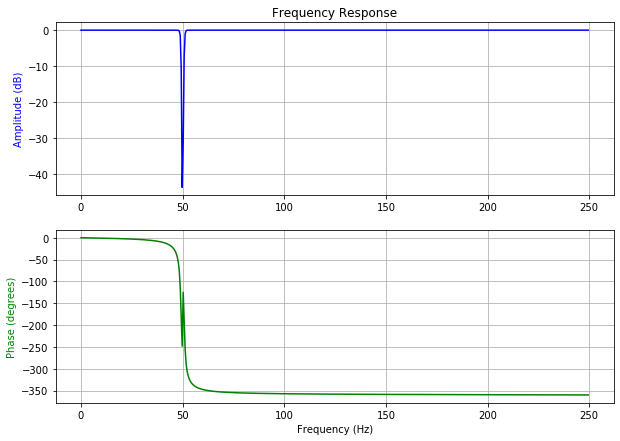


 BAND PASS FILTER (FIR)


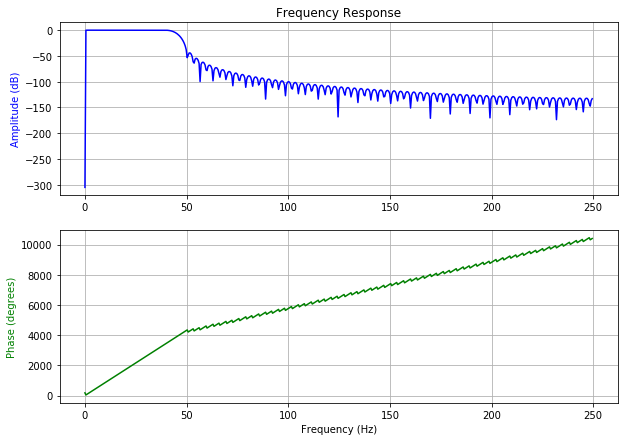

<RawBrainVision | Neuromarketing3850.eeg, 31 x 240140 (480.3 s), ~56.9 MB, data loaded>

In [4]:
# FILTERING
raw_filtered=raw.copy().set_montage("standard_1020",verbose=verbose) # No estoy segura de que sea este montaje¿?

#Notch filter (IIR)
print('\n','\033[1;34m' + 'NOTCH FILTER'+'\033[0;m')
f0=50
order=3
iir_params = dict(order=order, ftype='butter', output='ba')
iir_params = mne.filter.construct_iir_filter(iir_params,sfreq=sampling_freq, f_pass= [49, 51],btype='bandstop',return_copy=False, verbose=verbose)
b,a=(iir_params['b'],iir_params['a'])
plot_freq_response(b,a,sampling_freq)
raw_filtered.notch_filter(f0,method='iir',iir_params={'b':b,'a':a},verbose=verbose)
#plot_PSD(raw,raw_filtered, filter_applied='Notch filtered EEG signal')
#plt.show()

#Band pass filter (FIR)
print('\n','\033[1;34m' + 'BAND PASS FILTER (FIR)'+'\033[0;m')
f1,f2=(0.5,40)
numtap=20
numtaps=str(numtap)+'s' #filter lenght in sec
b = mne.filter.create_filter(raw_filtered['all'][1], filter_length=numtaps,sfreq=sampling_freq, l_freq=f1, h_freq=f2,
                             method='fir', fir_window='hann',fir_design='firwin', verbose=verbose)
plot_freq_response(b,1,sampling_freq)
raw_filtered.filter(l_freq=f1, h_freq=f2, filter_length=numtaps, method='fir', fir_window='hann', fir_design='firwin',verbose=verbose)
#plot_PSD(raw,bpfir_filtered, filter_applied='Band pass (FIR) filtered EEG signal')
#plt.show()

# ICA

In [5]:
ica = mne.preprocessing.ICA(n_components=5,method="infomax", fit_params=dict(extended=True),random_state=1,max_iter=300,verbose=verbose)
ica.fit(raw_filtered)

<ICA  |  raw data decomposition, fit (infomax): 240140 samples, 5 components, channels used: "eeg">

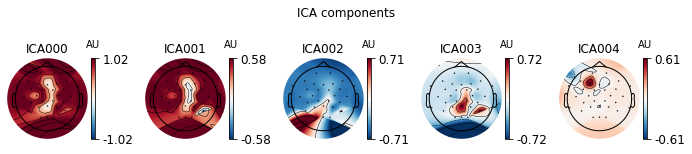

In [6]:
ica.plot_components(res=2**8, colorbar=True,outlines='skirt',contours=5, inst=ica,plot_std=True,image_args={'vmin':None})
plt.show()

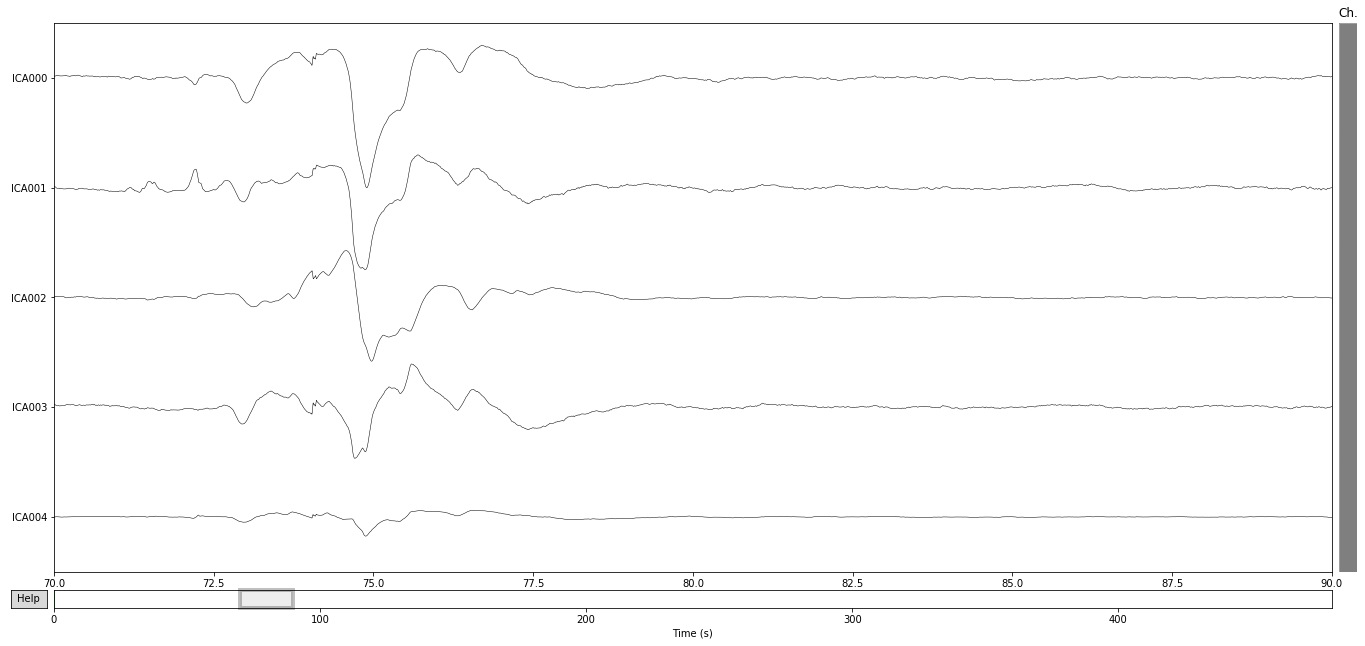

In [7]:
ica.plot_sources(raw_filtered,start=70)
plt.show()

In [8]:
#ica.exclude = [0,3]

In [9]:
raw_corrected = raw_filtered.copy()
ica.apply(raw_corrected)

Transforming to ICA space (5 components)
Zeroing out 0 ICA components


<RawBrainVision | Neuromarketing3850.eeg, 31 x 240140 (480.3 s), ~56.9 MB, data loaded>

# SEPARATE SPOTS

In [10]:
picks=[2,3,28,29] # Channels of interest [F3, F7, F4, F8]
ch_names=['F3', 'F7', 'F4', 'F8']
info_ch=mne.create_info(ch_names, sampling_freq, ch_types='eeg', verbose=verbose) # use raw.set_montage('standard_1020')
data,times=raw_corrected[:]

spots_times_sec = [0, 60, 120, 180, 226, 287, 347] # Time (sec) at which each spot begins
start_end=Get_Start_End(vmrk_files[i]) # markers of the spots: start and end
spots_time=Get_spot_start_samples(start_end,sampling_freq, spots_times_sec)

In [11]:
ba=[]
sp1=[]
sp2=[]
sp3=[]
sp4=[]
sp5=[]
sp6=[]
sp7=[]

for ch in picks:
    ba.append(data[ch,:spots_time[0]]) # Basal activity
    sp1.append(data[ch,spots_time[0]:spots_time[1]]) #1st spot
    sp2.append(data[ch,spots_time[1]:spots_time[2]]) #2nd spot
    sp3.append(data[ch,spots_time[2]:spots_time[3]]) #3rd spot
    sp4.append(data[ch,spots_time[3]:spots_time[4]]) #4th spot
    sp5.append(data[ch,spots_time[4]:spots_time[5]]) #5th spot
    sp6.append(data[ch,spots_time[5]:spots_time[6]]) #6th spot
    sp7.append(data[ch,spots_time[6]:]) #7th spot

ba  = mne.io.RawArray(ba, info_ch,verbose=verbose)
sp1 = mne.io.RawArray(sp1, info_ch,verbose=verbose)
sp2 = mne.io.RawArray(sp2, info_ch,verbose=verbose)
sp3 = mne.io.RawArray(sp3, info_ch,verbose=verbose)
sp4 = mne.io.RawArray(sp4, info_ch,verbose=verbose)
sp5 = mne.io.RawArray(sp5, info_ch,verbose=verbose)
sp6 = mne.io.RawArray(sp6, info_ch,verbose=verbose)
sp7 = mne.io.RawArray(sp7, info_ch,verbose=verbose)

In [12]:
#sp3.plot(scalings={"eeg": 75e-4})
#plt.show()

# FRECUENCY BANDS

### POTENCIAS TOTALES

#### POR ANUNCIO

In [13]:
P_ba=[]
P_sp1=[]
P_sp2=[]
P_sp3=[]
P_sp4=[]
P_sp5=[]
P_sp6=[]
P_sp7=[]

f1,f2 = (0.5,40)
spots=[ba,sp1,sp2,sp3,sp4,sp5,sp6,sp7]
for ch in range(len(picks)):
    f, Px = signal.periodogram(ba.get_data()[ch], sampling_freq) 
    idx = []
    for i in f:
        if i>f1 and i<=f2:
            idx.append(True)
        else:
            idx.append(False)
    P_ba.append(sum(Px[idx]))

    f, Px = signal.periodogram(sp1.get_data()[ch], sampling_freq) 
    idx = []
    for i in f:
        if i>f1 and i<=f2:
            idx.append(True)
        else:
            idx.append(False)
    P_sp1.append(sum(Px[idx]))

    f, Px = signal.periodogram(sp2.get_data()[ch], sampling_freq) 
    idx = []
    for i in f:
        if i>f1 and i<=f2:
            idx.append(True)
        else:
            idx.append(False)
    P_sp2.append(sum(Px[idx]))

    f, Px = signal.periodogram(sp3.get_data()[ch], sampling_freq) 
    idx = []
    for i in f:
        if i>f1 and i<=f2:
            idx.append(True)
        else:
            idx.append(False)
    P_sp3.append(sum(Px[idx]))

    f, Px = signal.periodogram(sp4.get_data()[ch], sampling_freq) 
    idx = []
    for i in f:
        if i>f1 and i<=f2:
            idx.append(True)
        else:
            idx.append(False)
    P_sp4.append(sum(Px[idx]))

    f, Px = signal.periodogram(sp5.get_data()[ch], sampling_freq) 
    idx = []
    for i in f:
        if i>f1 and i<=f2:
            idx.append(True)
        else:
            idx.append(False)
    P_sp5.append(sum(Px[idx]))

    f, Px = signal.periodogram(sp6.get_data()[ch], sampling_freq) 
    idx = []
    for i in f:
        if i>f1 and i<=f2:
            idx.append(True)
        else:
            idx.append(False)
    P_sp6.append(sum(Px[idx]))

    f, Px = signal.periodogram(sp7.get_data()[ch], sampling_freq) 
    idx = []
    for i in f:
        if i>f1 and i<=f2:
            idx.append(True)
        else:
            idx.append(False)
    P_sp7.append(sum(Px[idx]))

In [14]:
print('Potencia total del periodo de actividad basal previa a los anuncios:',round(sum(P_ba),5))
print('Potencia total del anuncio 1:',round(sum(P_sp1),5))
print('Potencia total del anuncio 2:',round(sum(P_sp2),5))
print('Potencia total del anuncio 3:',round(sum(P_sp3),5))
print('Potencia total del anuncio 4:',round(sum(P_sp4),5))
print('Potencia total del anuncio 5:',round(sum(P_sp5),5))
print('Potencia total del anuncio 6:',round(sum(P_sp6),5))
print('Potencia total del anuncio 7:',round(sum(P_sp7),5))
print('')

P_F3=[round(P_ba[0],5),round(P_sp1[0],5),round(P_sp2[0],5),round(P_sp3[0],5),round(P_sp4[0],5),round(P_sp5[0],5),round(P_sp6[0],5),round(P_sp7[0],5)]
P_F7=[round(P_ba[1],5),round(P_sp1[1],5),round(P_sp2[1],5),round(P_sp3[1],5),round(P_sp4[1],5),round(P_sp5[1],5),round(P_sp6[1],5),round(P_sp7[1],5)]
P_F4=[round(P_ba[2],5),round(P_sp1[2],5),round(P_sp2[2],5),round(P_sp3[2],5),round(P_sp4[2],5),round(P_sp5[2],5),round(P_sp6[2],5),round(P_sp7[2],5)]
P_F8=[round(P_ba[3],5),round(P_sp1[3],5),round(P_sp2[3],5),round(P_sp3[3],5),round(P_sp4[3],5),round(P_sp5[3],5),round(P_sp6[3],5),round(P_sp7[3],5)]
print('Potencias canal F3 por anuncio:', P_F3)
print('Potencias canal F7 por anuncio:', P_F7)
print('Potencias canal F4 por anuncio:', P_F4)
print('Potencias canal F8 por anuncio:', P_F8)
print('')

print('Potencia total canal F3:', round(sum(P_F3),5))
print('Potencia total canal F7:', round(sum(P_F7),5))
print('Potencia total canal F4:', round(sum(P_F4),5))
print('Potencia total canal F8:', round(sum(P_F8),5))

Potencia total del periodo de actividad basal previa a los anuncios: 0.00056
Potencia total del anuncio 1: 0.00463
Potencia total del anuncio 2: 0.00682
Potencia total del anuncio 3: 0.00307
Potencia total del anuncio 4: 0.00186
Potencia total del anuncio 5: 0.0089
Potencia total del anuncio 6: 0.00034
Potencia total del anuncio 7: 0.0018

Potencias canal F3 por anuncio: [0.00012, 0.00128, 0.00184, 0.00152, 0.00046, 0.00211, 8e-05, 0.00049]
Potencias canal F7 por anuncio: [0.0002, 0.00145, 0.00194, 0.00058, 0.00054, 0.00256, 0.0001, 0.0005]
Potencias canal F4 por anuncio: [5e-05, 0.00044, 0.00108, 0.00039, 0.00032, 0.00166, 7e-05, 0.00031]
Potencias canal F8 por anuncio: [0.00019, 0.00145, 0.00195, 0.00058, 0.00054, 0.00257, 0.0001, 0.0005]

Potencia total canal F3: 0.0079
Potencia total canal F7: 0.00787
Potencia total canal F4: 0.00432
Potencia total canal F8: 0.00788


##### POTENCIA EN LAS BANDAS DE FRECUENCIA

In [17]:
pot_alpha_F3=get_potencias(0,ba,sampling_freq)
pot_alpha_F7=get_potencias(1,ba,sampling_freq)
pot_alpha_F4=get_potencias(2,ba,sampling_freq)
pot_alpha_F8=get_potencias(3,ba,sampling_freq)

### POTENCIAS RELATIVAS

# INDEX